1) Checking resources

In [ ]:
train = False

In [1]:
!nvidia-smi

Mon Mar 28 11:35:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


2) Setting up colab

In [3]:
# Gloabal variables
data_path = "../input/"
model_path = "../../H5/PTB/RNN_ptb.h5"

random_seed = 50

In [4]:
# Mount Google Drive and set data paths.
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


3) Imports

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, optimizers, losses
from tensorflow.keras.layers import Input, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

4) Loading data

In [6]:
df_1 = pd.read_csv(data_path + "ptbdb_normal.csv", header=None)
df_2 = pd.read_csv(data_path + "ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

print("X shape is {}".format(X.shape))
print("Y shape is {}".format(Y.shape))
print("X_test shape is {}".format(X_test.shape))
print("Y_test shape is {}".format(Y_test.shape))

X shape is (11641, 187, 1)
Y shape is (11641,)
X_test shape is (2911, 187, 1)
Y_test shape is (2911,)


5) Visualizing data

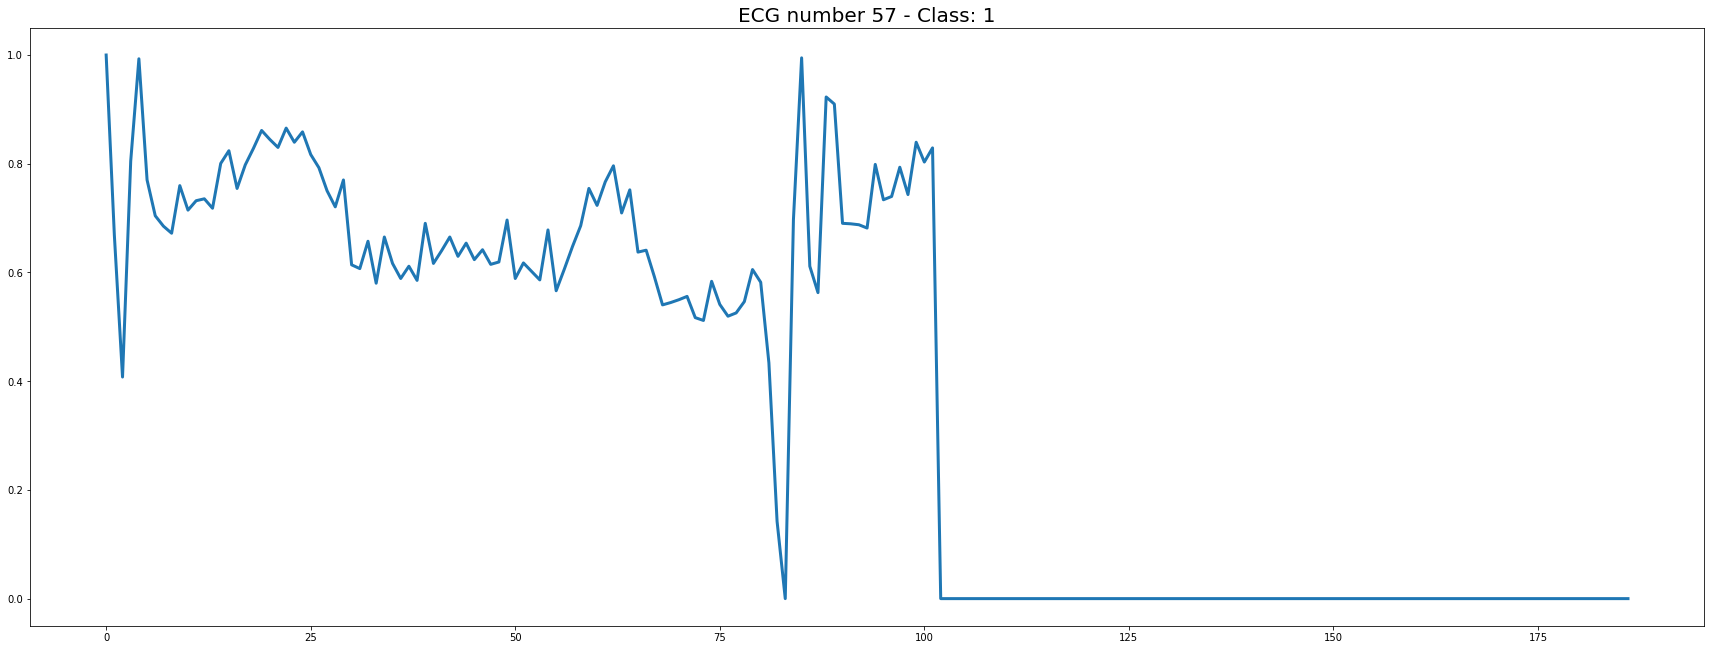

In [7]:
# Plotting one signal
example_signal = 56
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
plt.plot(X[example_signal])
plt.title("ECG number {} - Class: {}".format(example_signal+1, Y[example_signal]), size = 20)
plt.show()

6) Creating validation set

In [8]:
# Splitting dataset for validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)
for train_index, test_index in sss.split(X, Y):
    X_train, X_val = X[train_index], X[test_index]
    Y_train, Y_val = Y[train_index], Y[test_index]

print("X_train shape is {}".format(X_train.shape))
print("Y_train shape is {}".format(Y_train.shape))
print("X_val shape is {}".format(X_val.shape))
print("Y_val shape is {}".format(Y_val.shape))

X_train shape is (9312, 187, 1)
Y_train shape is (9312,)
X_val shape is (2329, 187, 1)
Y_val shape is (2329,)


6) Building SimpleRNN

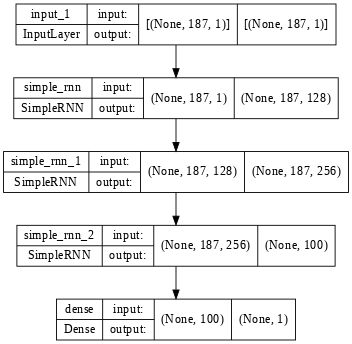

In [9]:
def getSimpleRNN(input_shape, lr=0.001, dr=0.2):

  inp = Input(shape=input_shape)
  img_1 = SimpleRNN(128, activation=None, dropout=dr, return_sequences=True, unroll=True)(inp)
  img_2 = SimpleRNN(256, activation=None, dropout=dr, return_sequences=True, unroll=True)(img_1)
  img_3 = SimpleRNN(100, activation=None, dropout=dr, return_sequences=False, unroll=True)(img_2)
  out = Dense(1, activation='sigmoid', use_bias=True)(img_3)

  model = models.Model(inputs=inp, outputs=out)
  opt = optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=losses.BinaryCrossentropy(name='bce', from_logits=False), metrics=['bce', 'acc'])
  
  return model

sRNN = getSimpleRNN(X_train[0].shape)
tf.keras.utils.plot_model(sRNN, show_shapes=True, dpi=64)

In [10]:
# Preparing the model
sRNN_file_path = model_path
checkpoint = ModelCheckpoint(sRNN_file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode="min", patience=25, verbose=1)
callbacks_list = [checkpoint, early]

In [11]:
# Fitting the model
if train:
    history = sRNN.fit(X_train, Y_train, epochs=1000, verbose=2, callbacks=callbacks_list, batch_size=128, validation_data=(X_val, Y_val))

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.90080, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNNBinary.h5
73/73 - 38s - loss: 87.8836 - bce: 87.8836 - acc: 0.6451 - val_loss: 0.9008 - val_bce: 0.9008 - val_acc: 0.7613 - 38s/epoch - 522ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.90080 to 0.61065, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNNBinary.h5
73/73 - 5s - loss: 1.3786 - bce: 1.3786 - acc: 0.6815 - val_loss: 0.6107 - val_bce: 0.6107 - val_acc: 0.7711 - 5s/epoch - 69ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.61065 to 0.55910, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNNBinary.h5
73/73 - 5s - loss: 1.0460 - bce: 1.0460 - acc: 0.6891 - val_loss: 0.5591 - val_bce: 0.5591 - val_acc: 0.7780 - 5s/epoch - 69ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.55910 to 0.47363, saving model to /content/gdrive/My Drive/ETH/MLH/Project1/model/simpleRNNBinary.h5
73/73 -

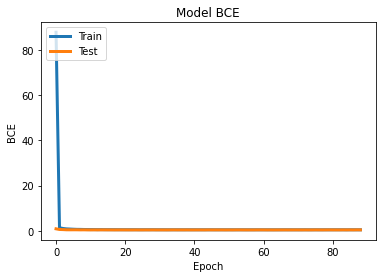

In [12]:
# Plot training & validation accuracy values
if train:
    plt.plot(history.history['bce'])
    plt.plot(history.history['val_bce'])
    plt.title('Model BCE')
    plt.ylabel('BCE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

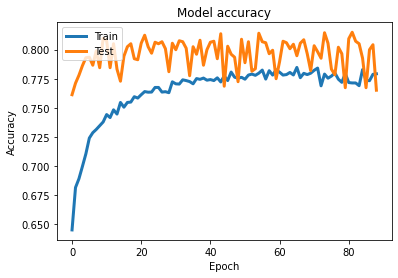

In [13]:
# Plot training & validation accuracy values
if train:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [14]:
# Analysis of the model
sRNN.load_weights(sRNN_file_path)
Y_pred_test = sRNN.predict(X_test)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
print("Model BCE: {}".format(bce(Y_test,Y_pred_test.flatten()).numpy()))
m = tf.keras.metrics.Accuracy()
m.update_state(Y_test.reshape(-1,1), Y_pred_test > 0.5)
print("Model accuracy: {}".format(m.result().numpy()))

Model BCE: 0.5437175035476685
Model accuracy: 0.7952593564987183


Model AUROC: 0.8571635231147217


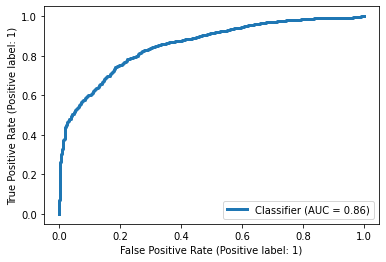

In [15]:
RocCurveDisplay.from_predictions(Y_test.reshape(-1,1), Y_pred_test)
print("Model AUROC: {}".format(roc_auc_score(Y_test.reshape(-1,1), Y_pred_test, average=None)))

Model AUPRC: 0.9403516253218164


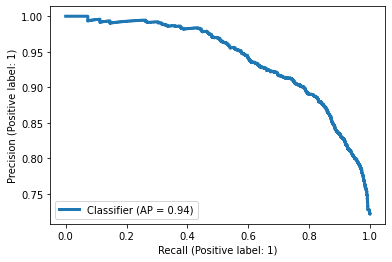

In [16]:
PrecisionRecallDisplay.from_predictions(Y_test.reshape(-1,1), Y_pred_test)
print("Model AUPRC: {}".format(average_precision_score(Y_test.reshape(-1,1), Y_pred_test)))